# BTC Hourly Close — Notebook R

> Objectif: découper l’analyse en petites cellules (étape par étape) avec des commentaires, pour que chaque tâche soit claire et exécutable indépendamment.

- Données: `data/btc_hourly_ohclv_ta.csv` (fallback: fichier à la racine)
- Colonne temps: `DATETIME`
- Variable d'intérêt: `Q = CLOSE`


### Cellule 1 — Packages
Chargement des bibliothèques R nécessaires.

In [ ]:
# 0) Packages (chargement des libs nécessaires)
suppressPackageStartupMessages({
  library(tidyverse)   # dplyr/ggplot2/readr/tidyr
  library(lubridate)   # parsing dates
  library(MASS)        # fitdistr (ajustement de distributions)
})

## 0 — Chargement des données
On localise le fichier CSV, on le charge, puis on prépare la colonne `DATETIME` et la série `Q` (le prix de clôture).

### Cellule 2 — Chemin + lecture du CSV
Détection du fichier et lecture dans `df_raw`.

In [ ]:
# 0.1) Trouver le chemin du CSV (data/ ou racine)
candidates <- c('data/btc_hourly_ohclv_ta.csv', 'btc_hourly_ohclv_ta.csv')
data_path <- candidates[file.exists(candidates)][1]
if (is.na(data_path)) {
  stop('Could not find BTC CSV. Tried: ', paste(candidates, collapse = ', '))
}
message('Using: ', data_path)

# 0.2) Charger le fichier
df_raw <- readr::read_csv(data_path, show_col_types = FALSE)

Using: data/btc_hourly_ohclv_ta.csv



### Cellule 3 — Nettoyage + création de `Q`
Parsing de `DATETIME`, conversion de `CLOSE` en `Q`, tri chronologique et contrôles rapides.

In [ ]:
# 0.3) Nettoyage minimal + création de Q
df <- df_raw %>%
  mutate(
    DATETIME = ymd_hms(DATETIME, quiet = TRUE),
    Q = as.numeric(CLOSE)
  ) %>%
  filter(!is.na(DATETIME), !is.na(Q)) %>%
  arrange(DATETIME)

# 0.4) Vérifications rapides
message('Rows: ', nrow(df), ' Cols: ', ncol(df))
message('Datetime range: ', min(df$DATETIME), ' -> ', max(df$DATETIME))
df %>% dplyr::select(DATETIME, Q) %>% head()

Rows: 91928 Cols: 29



Datetime range: 2014-12-15 06:00:00 -> 2025-11-22 23:00:00



DATETIME,Q
<dttm>,<dbl>
2014-12-15 06:00:00,349.54
2014-12-15 07:00:00,345.20
2014-12-15 08:00:00,345.81
2014-12-15 09:00:00,347.97
2014-12-15 10:00:00,346.98
2014-12-15 11:00:00,347.41


## Helpers (fonctions utilitaires)
On définit des fonctions simples réutilisées dans Task 1 (stats, ajustement de distributions, tests KS).

### Cellule 4 — Helpers (ECDF, AIC/BIC)
Fonctions utilitaires pour les comparaisons.

In [ ]:
# Helpers 1/4 — ECDF + critères d'information
ecdf_xy <- function(x) {
  # Empirical CDF (points x,y)
  x <- x[is.finite(x)]
  x <- sort(x)
  y <- seq_along(x) / length(x)
  list(x = x, y = y)
}

aic <- function(ll, k) 2 * k - 2 * ll
bic <- function(ll, k, n) k * log(n) - 2 * ll

### Cellule 5 — Helpers (stats descriptives)
Skewness, kurtosis et tableau de statistiques.

In [ ]:
# Helpers 2/4 — moments (skewness / kurtosis) + stats descriptives
skewness_simple <- function(x) {
  x <- x[is.finite(x)]
  m <- mean(x)
  s <- sd(x)
  if (!is.finite(s) || s == 0) return(NA_real_)
  mean(((x - m) / s)^3)
}

excess_kurtosis_simple <- function(x) {
  x <- x[is.finite(x)]
  m <- mean(x)
  s <- sd(x)
  if (!is.finite(s) || s == 0) return(NA_real_)
  mean(((x - m) / s)^4) - 3
}

summarize_series <- function(x) {
  # Table de stats + quantiles
  x <- x[is.finite(x)]
  p <- as.numeric(stats::quantile(
    x, probs = c(0.01, 0.05, 0.25, 0.75, 0.95, 0.99), names = FALSE
  ))
  tibble(
    n = length(x),
    min = min(x),
    max = max(x),
    mean = mean(x),
    median = median(x),
    sd = sd(x),
    skew = skewness_simple(x),
    excess_kurtosis = excess_kurtosis_simple(x),
    p01 = p[1],
    p05 = p[2],
    p25 = p[3],
    p75 = p[4],
    p95 = p[5],
    p99 = p[6]
  )
}

### Cellule 6 — Helpers (fit distributions)
Ajustement Normal / Lognormal / Gamma.

In [ ]:
# Helpers 3/4 — Ajustement de distributions (Task 1)
fit_norm <- function(x) {
  x <- x[is.finite(x)]
  mu <- mean(x)
  sigma <- sd(x)
  ll <- sum(dnorm(x, mean = mu, sd = sigma, log = TRUE))
  list(distribution = 'norm', params = list(mean = mu, sd = sigma), ll = ll, k = 2, n = length(x))
}

fit_lognorm <- function(x) {
  # Lognormal nécessite x > 0
  x <- x[is.finite(x) & x > 0]
  fit <- MASS::fitdistr(x, densfun = 'lognormal')
  ll <- as.numeric(logLik(fit))
  list(distribution = 'lognorm', params = as.list(fit$estimate), ll = ll, k = 2, n = length(x))
}

fit_gamma <- function(x) {
  # Gamma nécessite x > 0
  x <- x[is.finite(x) & x > 0]
  out <- tryCatch({
    fit <- MASS::fitdistr(x, densfun = 'gamma')
    params <- as.list(fit$estimate)
    ll <- as.numeric(logLik(fit))
    list(params = params, ll = ll)
  }, error = function(e) {
    # Fallback: méthode des moments (plus robuste)
    m <- mean(x)
    v <- stats::var(x)
    if (!is.finite(v) || v <= 0) {
      return(list(params = list(shape = NA_real_, rate = NA_real_), ll = NA_real_))
    }
    shape <- m^2 / v
    rate <- m / v
    ll <- sum(dgamma(x, shape = shape, rate = rate, log = TRUE))
    list(params = list(shape = shape, rate = rate), ll = ll)
  })
  list(distribution = 'gamma', params = out$params, ll = out$ll, k = 2, n = length(x))
}

### Cellule 7 — Helpers (KS test)
Fonction `ks_pvalue()` pour comparer distribution vs données.

In [ ]:
# Helpers 4/4 — KS test (p-value)
ks_pvalue <- function(x, dist, params) {
  # Note: p-value approximative car paramètres estimés sur les mêmes données.
  x <- x[is.finite(x)]
  out <- tryCatch({
    if (dist == 'norm') {
      stats::ks.test(x, 'pnorm', mean = params$mean, sd = params$sd)$p.value
    } else if (dist == 'lognorm') {
      stats::ks.test(x, 'plnorm', meanlog = params$meanlog, sdlog = params$sdlog)$p.value
    } else if (dist == 'gamma') {
      stats::ks.test(x, 'pgamma', shape = params$shape, rate = params$rate)$p.value
    } else {
      NA_real_
    }
  }, error = function(e) NA_real_)
  as.numeric(out)
}

## Task 1 — Distribution (Q = CLOSE)

We compute descriptive stats, fit candidate distributions (Normal / Lognormal / Gamma), compare them with log-likelihood + AIC/BIC, and visualize fit quality.

### Cellule 8 — Task 1 (préparation + stats)
Préparer `Q` / `Q_pos` et afficher les stats descriptives.

In [ ]:
# Task 1.1) Préparer la série Q
Q <- df$Q
Q <- Q[is.finite(Q)]

# Pour lognormal/gamma (valeurs strictement positives)
Q_pos <- Q[Q > 0]

# Task 1.2) Statistiques descriptives
stats_table <- summarize_series(Q)
stats_table

n,min,max,mean,median,sd,skew,excess_kurtosis,p01,p05,p25,p75,p95,p99
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
91928,165.07,126113.7,26829.32,10966.22,31328.78,1.360715,0.9332628,226.37,255.0305,3579.785,42042.43,102331.6,116765.8


### Cellule 9 — Task 1 (fit + comparaison)
Ajuster les distributions et produire le tableau AIC/BIC/KS.

In [ ]:
# Task 1.3) Ajuster et comparer des distributions
# - Normal: sur toute la série Q
# - Lognormal/Gamma: sur Q_pos (strictement positif)
fits <- list(
  fit_norm(Q),
  fit_lognorm(Q_pos),
  fit_gamma(Q_pos)
 )

comparison <- purrr::map_dfr(fits, function(f) {
  x_for_ks <- if (f$distribution == 'norm') Q else Q_pos
  tibble(
    distribution = f$distribution,
    n_used = f$n,
    loglik = f$ll,
    AIC = aic(f$ll, f$k),
    BIC = bic(f$ll, f$k, f$n),
    KS_p = ks_pvalue(x_for_ks, f$distribution, f$params)
  )
}) %>% arrange(AIC, BIC)

comparison

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"


Warning message in ks.test.default(x, "pnorm", mean = params$mean, sd = params$sd):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"


Warning message in ks.test.default(x, "plnorm", meanlog = params$meanlog, sdlog = params$sdlog):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"


Warning message in ks.test.default(x, "pgamma", shape = params$shape, rate = params$rate):
"ties should not be present for the one-sample Kolmogorov-Smirnov test"


distribution,n_used,loglik,AIC,BIC,KS_p
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
gamma,91928,-1019323,2038649,2038668,0
lognorm,91928,-1024662,2049328,2049347,0
norm,91928,-1082105,2164214,2164233,0


### Cellule 10 — Task 1 (Plot 1/4)
Histogramme + densités (PDF) ajustées.

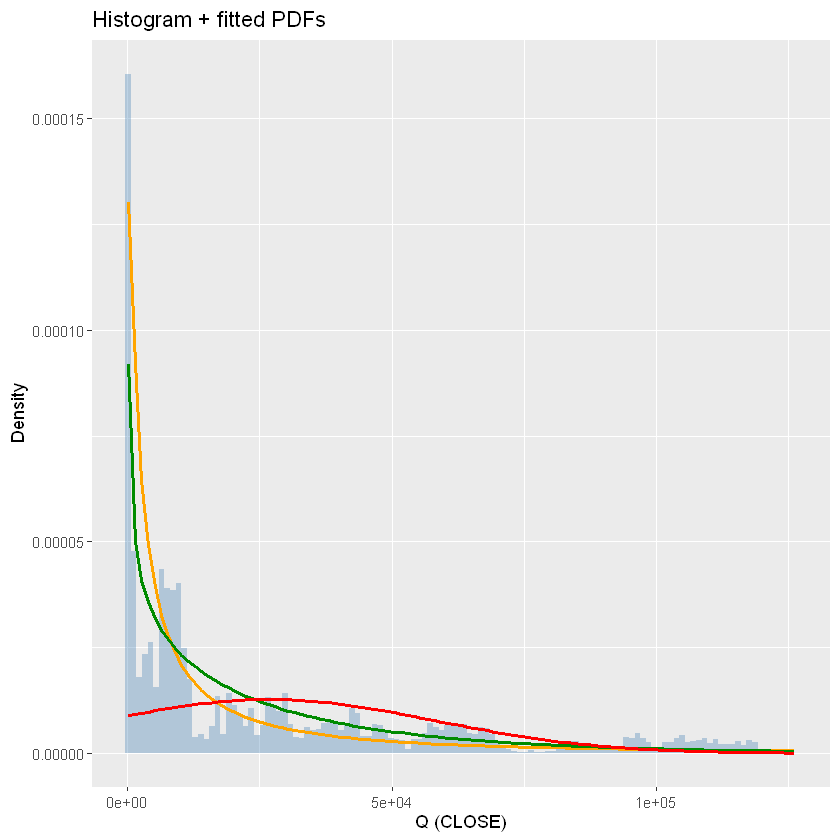

In [ ]:
# Task 1.4) Plot 1/4 — Histogramme + PDFs ajustées
fits_named <- purrr::set_names(fits, purrr::map_chr(fits, 'distribution'))

ggplot(tibble(Q = Q_pos), aes(Q)) +
  geom_histogram(aes(y = after_stat(density)), bins = 120, fill = 'steelblue', alpha = 0.35) +
  stat_function(fun = dlnorm, args = fits_named$lognorm$params, linewidth = 1, colour = 'orange') +
  stat_function(fun = dgamma, args = fits_named$gamma$params, linewidth = 1, colour = 'green4') +
  stat_function(fun = dnorm, args = fits_named$norm$params, linewidth = 1, colour = 'red') +
  labs(title = 'Histogram + fitted PDFs', x = 'Q (CLOSE)', y = 'Density')

### Cellule 11 — Task 1 (Plot 2/4)
ECDF des données + CDFs des distributions ajustées.

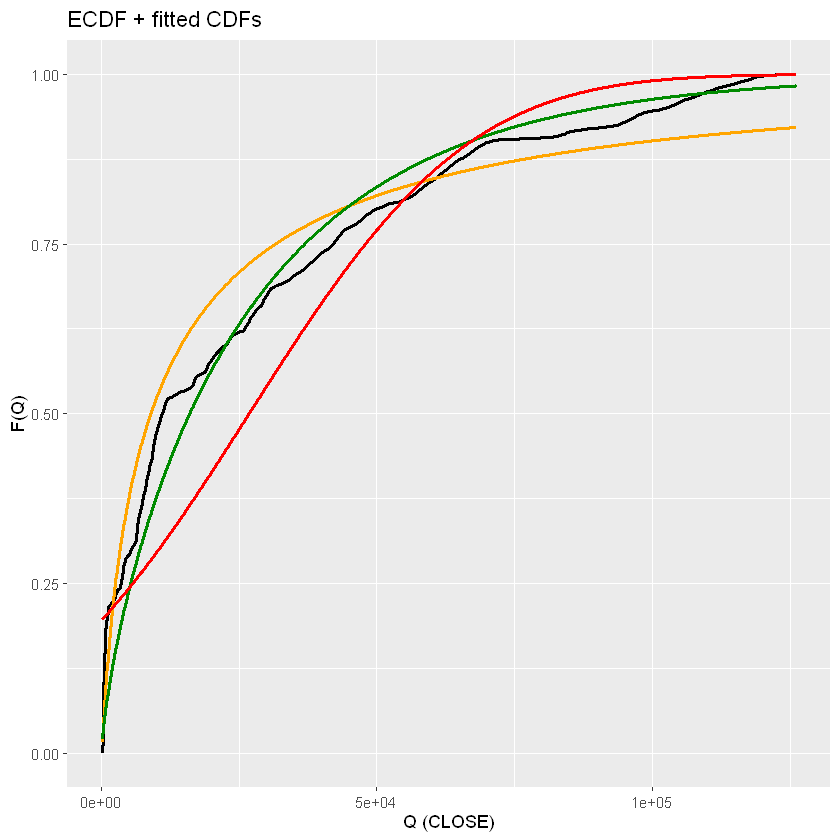

In [ ]:
# Task 1.5) Plot 2/4 — ECDF + CDFs ajustées
xgrid <- seq(min(Q_pos), max(Q_pos), length.out = 2000)
ec <- ecdf(Q_pos)

ggplot() +
  geom_step(aes(xgrid, ec(xgrid)), linewidth = 1, colour = 'black') +
  geom_line(aes(xgrid, plnorm(xgrid, !!!fits_named$lognorm$params)), linewidth = 1, colour = 'orange') +
  geom_line(aes(xgrid, pgamma(xgrid, !!!fits_named$gamma$params)), linewidth = 1, colour = 'green4') +
  geom_line(aes(xgrid, pnorm(xgrid, !!!fits_named$norm$params)), linewidth = 1, colour = 'red') +
  labs(title = 'ECDF + fitted CDFs', x = 'Q (CLOSE)', y = 'F(Q)')

### Cellule 12 — Task 1 (Plot 3/4)
QQ-plot de `log(Q)` vs Normal.

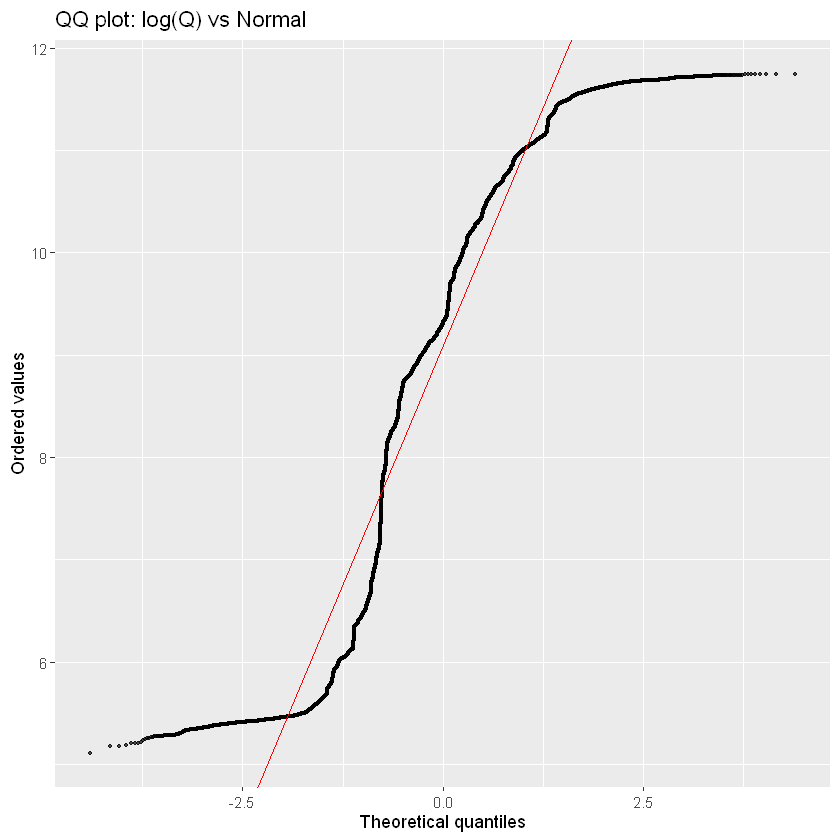

In [ ]:

# Task 1.6) Plot 3/4 — QQ plot: log(Q) vs Normal
logQ <- log(Q_pos)
qq <- qqnorm(logQ, plot.it = FALSE)
qq_df <- tibble(theoretical = qq$x, ordered = qq$y)

ggplot(qq_df, aes(theoretical, ordered)) +
  geom_point(size = 0.8, alpha = 0.7) +
  geom_abline(intercept = mean(logQ), slope = sd(logQ), colour = 'red') +
  labs(title = 'QQ plot: log(Q) vs Normal', x = 'Theoretical quantiles', y = 'Ordered values')

### Task 1 — Plot 4/4
Densité de `Q` avec l’axe des x en échelle log10 (pour mieux voir la forme sur plusieurs ordres de grandeur).

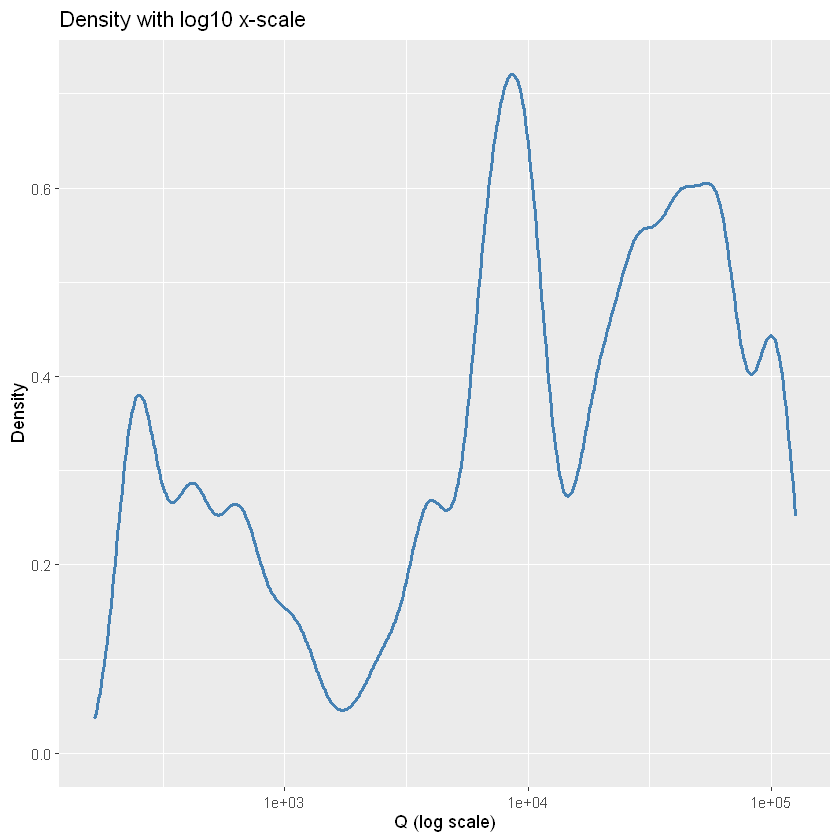

In [ ]:
# Task 1.7) Plot 4/4 — Densité (axe x en log10)
ggplot(tibble(Q = Q_pos), aes(Q)) +
  geom_density(linewidth = 1, colour = 'steelblue') +
  scale_x_log10() +
  labs(title = 'Density with log10 x-scale', x = 'Q (log scale)', y = 'Density')

## Task 2 — Dry & Wet Years

We identify the 2 driest and 2 wettest years based on annual mean(Q), then compare intra-annual behavior (time series, cumulative, monthly distribution, monthly mean).

### Cellule 13 — Task 2 (sélection des années)
Calcul annuel (mean_Q) + sélection 2 années “dry” et 2 “wet”.

In [ ]:
d <- df %>% mutate(YEAR = year(DATETIME), MONTH = month(DATETIME))

annual <- d %>%
  group_by(YEAR) %>%
  summarise(mean_Q = mean(Q), n = n(), .groups = 'drop') %>%
  arrange(mean_Q)

selected_dry <- annual %>% slice_head(n = 2) %>% mutate(label = 'dry')
selected_wet <- annual %>% slice_tail(n = 2) %>% mutate(label = 'wet')
selected <- bind_rows(selected_dry, selected_wet) %>% arrange(label, mean_Q)
selected_years <- selected$YEAR
selected

YEAR,mean_Q,n,label
<dbl>,<dbl>,<int>,<chr>
2015,272.0806,8395,dry
2014,322.8131,386,dry
2024,65903.0369,8418,wet
2025,103158.0096,7523,wet


### Cellule 14 — Task 2 (tableau annuel)
Aperçu du tableau `annual` (mean_Q par année).

In [ ]:
# --- Annual summary table (preview)
annual %>% head(10)

YEAR,mean_Q,n
<dbl>,<dbl>,<int>
2015,272.0806,8395
2014,322.8131,386
2016,566.3601,8418
2017,3957.7081,8395
2019,7370.2319,8395
2018,7547.6557,8395
2020,11079.2288,8418
2022,28224.3856,8395
2023,28814.5127,8395


### Cellule 15 — Task 2 (signature saisonnière)
Stats mensuelles (mean/median/quantiles) pour les années sélectionnées.

In [ ]:
# --- Seasonal signature table for selected years
sel <- d %>% filter(YEAR %in% selected_years)

seasonal_signature <- sel %>%
  group_by(YEAR, MONTH) %>%
  summarise(
    mean_Q = mean(Q),
    median_Q = median(Q),
    q25 = quantile(Q, 0.25),
    q75 = quantile(Q, 0.75),
    n = n(),
    .groups = 'drop'
  )
seasonal_signature %>% head(12)

YEAR,MONTH,mean_Q,median_Q,q25,q75,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2014,12,322.8131,320.915,315.0100,330.5925,386
2015,1,250.4236,247.400,218.9700,276.9400,713
2015,2,233.7227,235.715,224.1975,241.3400,644
2015,3,268.4983,269.000,252.5900,283.4300,713
2015,4,234.6036,233.785,224.4800,244.3325,690
2015,5,237.3326,237.070,235.3000,239.8100,713
2015,6,237.5026,237.245,228.4600,245.1800,690
2015,7,278.5453,277.880,269.7200,288.5600,713
2015,8,251.9841,258.340,229.5600,268.9600,713


### Task 2 — Plot 1/4
Série temporelle de `Q` pour les années sélectionnées (facets par année).

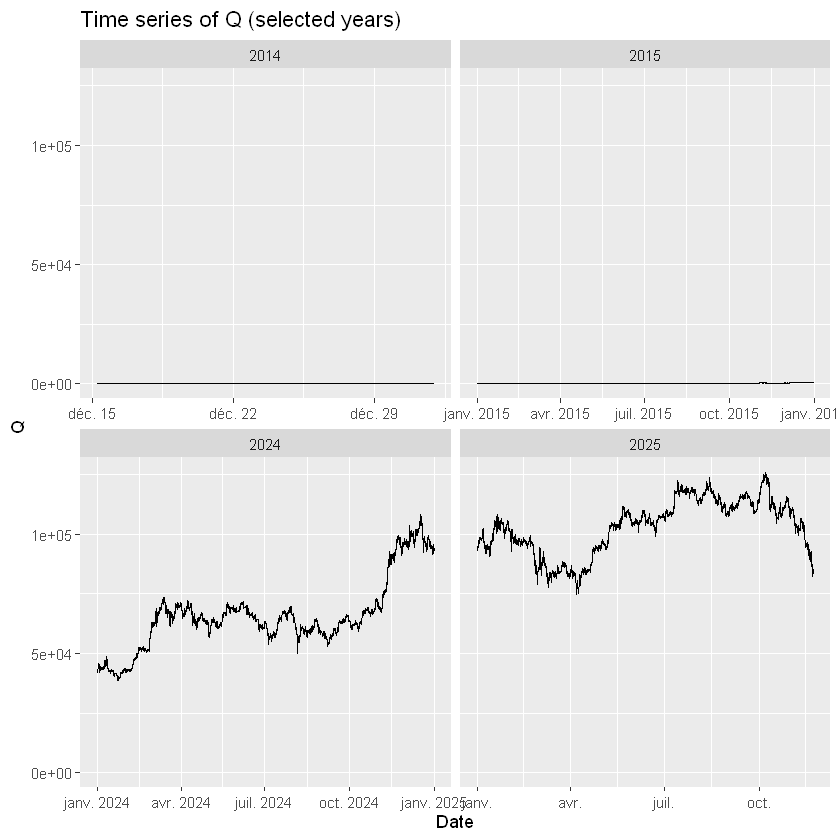

In [ ]:
# Task 2.1) Plot 1/4 — Time series (faceted by year)
ggplot(sel, aes(DATETIME, Q)) +
  geom_line(linewidth = 0.3) +
  facet_wrap(~ YEAR, scales = 'free_x', ncol = 2) +
  labs(title = 'Time series of Q (selected years)', x = 'Date', y = 'Q')

### Task 2 — Plot 2/4
Somme cumulée annuelle de `Q` à l’intérieur de chaque année sélectionnée.

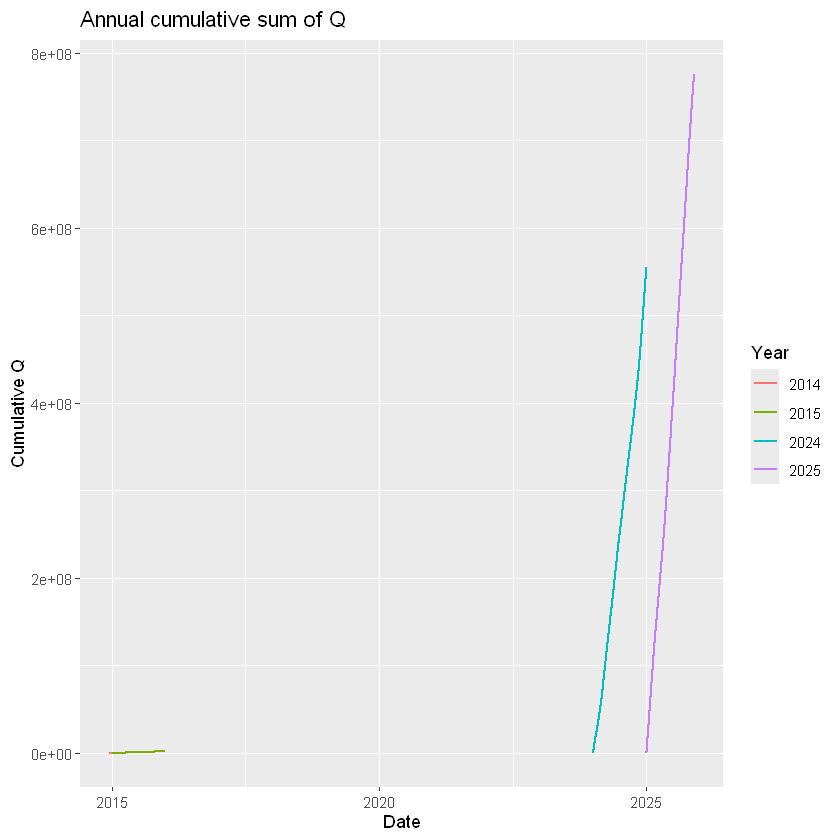

In [ ]:
# Task 2.2) Plot 2/4 — Cumulative sum within year
cum_df <- sel %>%
  arrange(YEAR, DATETIME) %>%
  group_by(YEAR) %>%
  mutate(cum_Q = cumsum(Q)) %>%
  ungroup()

ggplot(cum_df, aes(DATETIME, cum_Q, colour = factor(YEAR))) +
  geom_line(linewidth = 0.6) +
  labs(title = 'Annual cumulative sum of Q', x = 'Date', y = 'Cumulative Q', colour = 'Year')

### Task 2 — Plot 3/4
Boxplots mensuels de `Q` (comparaison des années sélectionnées).

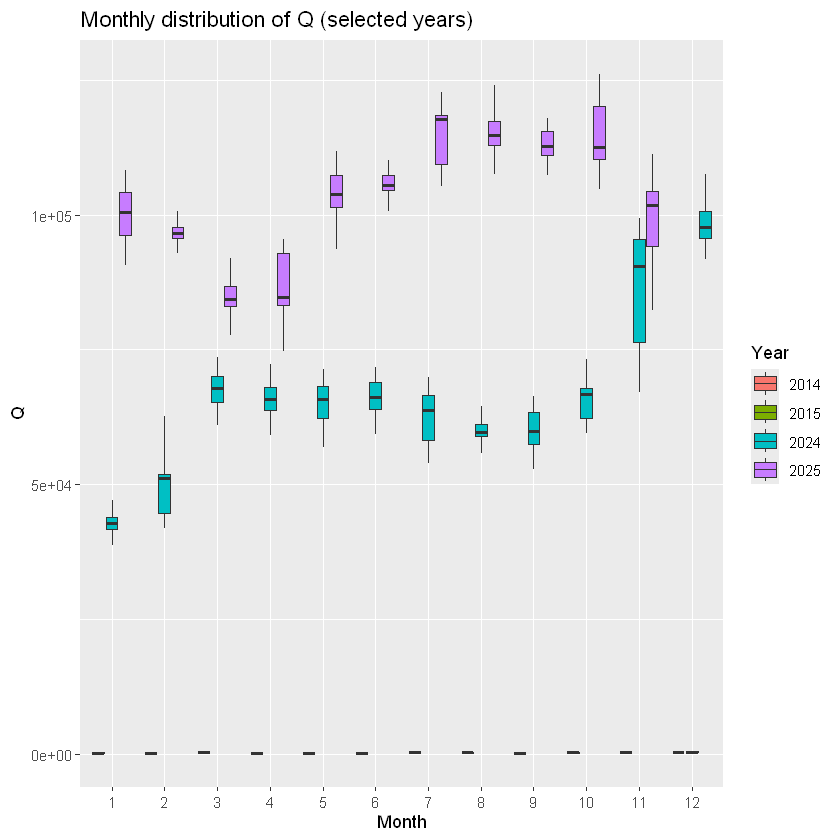

In [ ]:
# Task 2.3) Plot 3/4 — Monthly boxplots
ggplot(sel, aes(factor(MONTH), Q, fill = factor(YEAR))) +
  geom_boxplot(outlier.shape = NA) +
  labs(title = 'Monthly distribution of Q (selected years)', x = 'Month', y = 'Q', fill = 'Year')

### Task 2 — Plot 4/4
Moyenne mensuelle de `Q` (courbes par année).

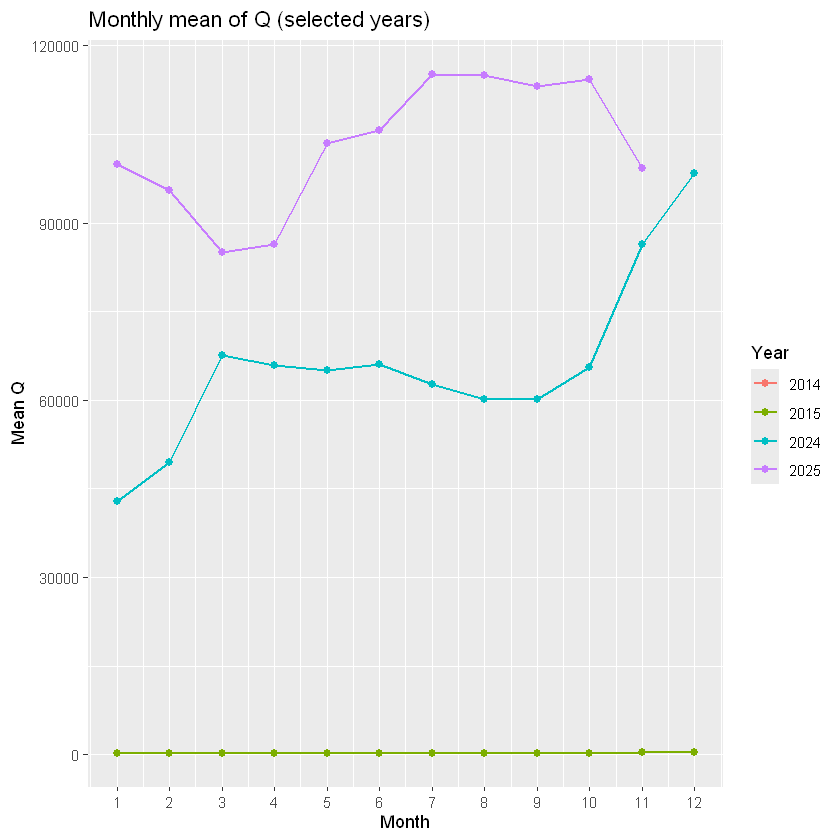

In [ ]:
# Task 2.4) Plot 4/4 — Monthly mean lines
monthly_means <- sel %>%
  group_by(YEAR, MONTH) %>%
  summarise(mean_Q = mean(Q), .groups = 'drop')

ggplot(monthly_means, aes(MONTH, mean_Q, colour = factor(YEAR))) +
  geom_line(linewidth = 0.8) +
  geom_point(size = 2) +
  scale_x_continuous(breaks = 1:12) +
  labs(title = 'Monthly mean of Q (selected years)', x = 'Month', y = 'Mean Q', colour = 'Year')

## Task 3 — Predict next-hour BTC price (R)

We predict the next-hour close price using information available at time $t$.

- Target: `y = lead(Q, 1)`
- Split: time-based (first 80% train, last 20% test)
- Models: naive persistence baseline vs linear regression


### Task 3 — Dataset & split
Création des features (lags/returns) et split temporel train/test.

In [ ]:
# Task 3.1) Construire le dataset de modélisation
model_df <- df %>%
  arrange(DATETIME) %>%
  mutate(
    y = dplyr::lead(Q, 1),
    lag1 = dplyr::lag(Q, 1),
    lag24 = dplyr::lag(Q, 24),
    ret1 = Q / dplyr::lag(Q, 1) - 1
  ) %>%
  dplyr::select(
    DATETIME, Q, y,
    lag1, lag24, ret1,
    SMA_20, EMA_12, EMA_26,
    MACD, MACD_SIGNAL, MACD_DIFF,
    RSI, BB_WIDTH,
    STOCH_K, STOCH_D,
    MFI, ATR,
    VOLATILITY_30D, PRICE_VOLATILITY_30D, HL_VOLATILITY_30D
  ) %>%
  tidyr::drop_na()

# Task 3.2) Split temporel (80/20)
n_total <- nrow(model_df)
train_n <- floor(0.80 * n_total)
train <- model_df[1:train_n, ]
test <- model_df[(train_n + 1):n_total, ]

c(n_total = n_total, train_n = nrow(train), test_n = nrow(test))

n_total train_n  test_n 
  91903   73522   18381

### Task 3 — Métriques
Définition des métriques d’évaluation (RMSE/MAE/MAPE).

In [ ]:
rmse <- function(y, yhat) sqrt(mean((yhat - y)^2))
mae <- function(y, yhat) mean(abs(yhat - y))
mape <- function(y, yhat) mean(abs((yhat - y) / y)) * 100

### Task 3 — Entraînement & évaluation
Baseline naïf (persistence) vs régression linéaire + tableau des métriques.

In [ ]:
# Baseline: persistence (yhat = Q_t)
test$pred_naive <- test$Q

# Linear regression
fit_lm <- lm(
  y ~ lag1 + lag24 + ret1 + SMA_20 + RSI + MACD + BB_WIDTH + ATR + VOLATILITY_30D,
  data = train
)
test$pred_lm <- predict(fit_lm, newdata = test)

# Tableau de métriques
tibble(
  model = c('naive_persistence', 'linear_regression'),
  RMSE = c(rmse(test$y, test$pred_naive), rmse(test$y, test$pred_lm)),
  MAE  = c(mae(test$y, test$pred_naive),  mae(test$y, test$pred_lm)),
  MAPE = c(mape(test$y, test$pred_naive), mape(test$y, test$pred_lm))
)

model,RMSE,MAE,MAPE
<chr>,<dbl>,<dbl>,<dbl>
naive_persistence,406.8319,255.7608,0.3365597
linear_regression,518.7904,326.4704,0.4237067


### Task 3 — Plot 1/2
Séries temporelles (dernier segment du test): réel vs prédictions.

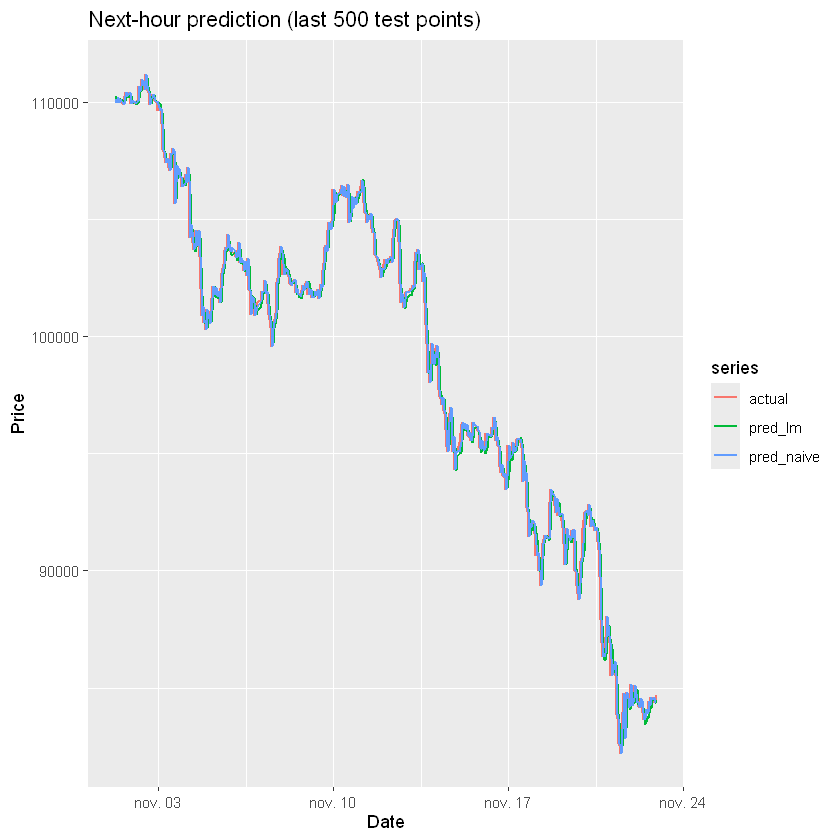

In [ ]:
# Task 3.3) Plot 1/2 — Courbes sur les derniers points du test
N <- min(500, nrow(test))
plot_df <- test %>%
  tail(N) %>%
  dplyr::select(DATETIME, actual = y, pred_naive, pred_lm) %>%
  tidyr::pivot_longer(
    cols = c(actual, pred_naive, pred_lm),
    names_to = 'series',
    values_to = 'value'
  )

ggplot(plot_df, aes(DATETIME, value, colour = series)) +
  geom_line(linewidth = 0.6) +
  labs(title = 'Next-hour prediction (last 500 test points)', x = 'Date', y = 'Price')

### Task 3 — Plot 2/2
Scatter prédiction vs réel (test) avec la diagonale $y=x$.

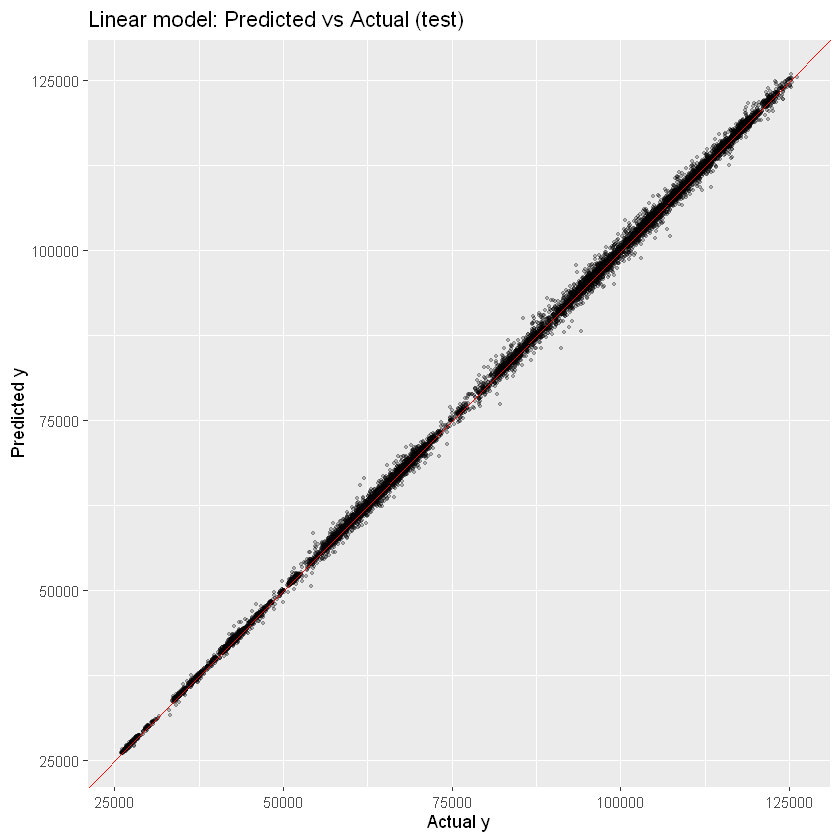

In [ ]:
# Task 3.4) Plot 2/2 — Scatter predicted vs actual
ggplot(test, aes(y, pred_lm)) +
  geom_point(alpha = 0.25, size = 0.8) +
  geom_abline(intercept = 0, slope = 1, colour = 'red') +
  labs(title = 'Linear model: Predicted vs Actual (test)', x = 'Actual y', y = 'Predicted y')